This notebook was created at 10:27 13/10/20

LeNet-5 inspired CCN architecture applied to classification of isotropic and liquid crystal (LC) textures

This notebook is meant as an initial proof-of-concept for the overall aim of classifying LC phases from textures. This proof-of-concept will be to test the binary classification of textures representing isotopic and non-isotropic (LC) phases. 

Isotropic is represented as an (almost) completely black simulated image. This is the texture obtained for an isotropic phase using the method of polarizing microscopy. The LC phase will be represented by textures obtained via Youtube videos - (INCLUDE LINKS HERE).

Specifically this classification will be implemented using a simple convolutional network (CNN) - LeNet-5 inspired - as this is a CNN that is not to computationally expensive for this task, but should be applicable when generalising the classification to multiple textures.

Additionally this notebook specifically wants to sort the data leakage problem of past notebooks by not allowing photos from the same YouTube video.

We'll be using keras and/or tensorflow.

In [1]:
pip install tensorflow keras numpy matplotlib

Note: you may need to restart the kernel to use updated packages.


In [2]:
# IMPORTS
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
from keras import layers
from keras.layers import Input, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D
from keras.layers import AveragePooling2D, MaxPooling2D, Dropout, GlobalMaxPooling2D, GlobalAveragePooling2D
from keras.models import Model
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split

import keras.backend as K

Define the function for generating the simulated texture images. The images will be 368(height)x640(width) (a choice made so that the size matches the size of the pictures taken from Youtube videos). 

In [3]:
def random_image_and_labels_generator(image_shape, N):
    """
    Generates random images and their corresponding labels
    (0 for dark/isotropic)

    Parameters
    ----------
    image_shape : tuple
        Shape of images we want to generate
    N : int
        number of images we want to generate

    Returns
    -------
    images : np.array
        Generated images together in an array of size (N, image height, image width, 1)
    labels : np.array
        The corresponding labels for the generated images of shape (N, 1)

    """
    # Add the images to an array
    images = np.zeros((1, image_shape[0], image_shape[1], 3)) # we'll need to remove this entry of zeros
    
    for i in range(N):
        # Generate image of size image_size with random
        # pixel values between 0 and 1 (representing a random
        # normalized image)
        image = np.random.rand(1, image_shape[0], image_shape[1], 3) # size (pixels, pixels)
        images = np.concatenate((images, image), axis = 0) # will be size (N, pixels, pixels)
    
    images = np.delete(images, 0, axis = 0)
    # Generate labels, 1
    labels = np.zeros((N, 1))
    
    return images, labels

In [4]:
def generate_data(image_shape):
    """
    Generate the data for this classification problem and get data from images obtained from YouTube - holding one video's 
    images for test set only

    Parameters
    ----------
    image_shape : tuple
        Shape of images we're dealing with
    N_isotropic : int
        Number of isotropic examples we're generating for the dataset

    Returns
    -------
    images_shuffled : np.array
        Shuffled images that were generated of size (N_examples, image height, image width, 1)
    labels_shuffled : np.array
        Labels corresponding to the shuffled images, 1 for LC and 0 for isotropic, of size (N_examples, 1)

    """
    height = image_shape[0]
    width = image_shape[1]
    
    # Get Youtube LC images and labels (1 for LC image)
    vid_file_path = "C:/Users/Jason/Documents/University/Year_4/MPhys_Project(s)/Liquid_crystals-machine_learning/Images/"
    images_LC = np.zeros((1, height, width, 3)) # we'll need to remove this entry of zeros
    images_LC_test = np.zeros((1, height, width, 3))
    for i in range(1, 552, 10): #552
        image = np.array(Image.open(vid_file_path + 'Youtube-Vance_Williams-Cholesteric_heating%05d.jpeg' %(i))).reshape((1, height, width, 3)) / 255
        images_LC_test = np.concatenate((images_LC_test, image), axis = 0)
    print("First set of images loaded!")
    for i in range(1, 842, 10): #842
        image = np.array(Image.open(vid_file_path + 'Youtube-Vance_Williams-Cholesteric_to_Isotropic_transition%05d.jpeg' %(i))).reshape((1, height, width, 3)) / 255
        images_LC = np.concatenate((images_LC, image), axis = 0)
    print("Second set of images loaded!")
    for i in range(1, 752, 10): #752
        image = np.array(Image.open(vid_file_path + 'Youtube-Vance_Williams-Isotropic_to_Cholesteric_transition%05d.jpeg' %(i))).reshape((1, height, width, 3)) / 255
        images_LC = np.concatenate((images_LC, image), axis = 0)
    print("Third set of images loaded!")
    for i in range(1, 632, 10): #632
        image = np.array(Image.open(vid_file_path + 'Youtube-Vance_Williams-Youtube-Vance_Williams-Smectic_C_to_Nematic_transition%05d.jpeg' %(i))).reshape((1, height, width, 3)) / 255
        images_LC = np.concatenate((images_LC, image), axis = 0)
    print("Fourth set of images loaded!")
    images_LC = np.delete(images_LC, 0, axis = 0)
    images_LC_test = np.delete(images_LC_test, 0, axis = 0)
    # Generate labels (1 for LC)
    N_LC = images_LC.shape[0]
    labels_LC = np.zeros((N_LC, 1)) + 1
    N_LC_test = images_LC_test.shape[0]
    labels_LC_test = np.zeros((N_LC_test, 1)) + 1
    
    # Generate isotropic images and labels (0 for
    # isotropic image) by adding zeros to dataset
    # Train
    images_train_iso, _ = random_image_and_labels_generator(image_shape, N_LC)
    images_train_iso_noise = images_train_iso * 0.1 # this should simulate noisy isotropic images
    labels_train_iso = np.zeros((N_LC, 1))
    # Test
    images_test_iso, _ = random_image_and_labels_generator(image_shape, N_LC_test)
    images_test_iso_noise = images_test_iso * 0.1 # this should simulate noisy isotropic images
    labels_test_iso = np.zeros((N_LC_test, 1))
    
    images_train_ordered = np.concatenate((images_LC, images_train_iso_noise), axis = 0)
    labels_train_ordered = np.concatenate((labels_LC, labels_train_iso), axis = 0)
    images_test_ordered = np.concatenate((images_LC_test, images_test_iso_noise), axis = 0)
    labels_test_ordered = np.concatenate((labels_LC_test, labels_test_iso), axis = 0)

    # randomly shuffle the LC and iso images and labels
    images_train_shuffled, labels_train_shuffled = shuffle(images_train_ordered, labels_train_ordered)
    images_test_shuffled, labels_test_shuffled = shuffle(images_test_ordered, labels_test_ordered)
    
    print("All data loaded and shuffled!")
    
    return images_train_shuffled, labels_train_shuffled, images_test_shuffled, labels_test_shuffled

Generate some data. (This could take a minute or so.)

In [5]:
image_shape = (368,640)
images_train, labels_train, images_test, labels_test = generate_data(image_shape)

First set of images loaded!
Second set of images loaded!
Third set of images loaded!
Fourth set of images loaded!
All data loaded and shuffled!


Let's look at some of the images and make sure the labels are matching up.

In [ ]:
plt.imshow(images_train[9,:,:,:])
print("Label: %i"%labels_train[9])

#plt.imshow(images_test[3,:,:,:])
#print("Label: %i"%labels_test[3])

In [ ]:
print ("number of training examples = " + str(images_train.shape[0]))
print ("number of test examples = " + str(images_test.shape[0]))
print ("X_train shape: " + str(images_train.shape))
print ("Y_train shape: " + str(labels_train.shape))
print ("X_test shape: " + str(images_test.shape))
print ("Y_test shape: " + str(labels_test.shape))

Define the LeNet-5 model.

In [10]:
def leNet5(input_shape):
    """
    Create an instance of model class representing LeNet-5
    inspired architecture

    Parameters
    ----------
    input_shape : tuple
        shape to be input to the CNN

    Returns
    -------
    model : instance of model class
        our LeNet-5 inspired model

    """
    # Input placeholder with shape input_shape
    X_input = Input(input_shape)
    
    # Apply 6 5x5 filter convolution with stride of 1
    X = Conv2D(6, (5,5), strides = (1,1), activation = "relu", name = "conv1")(X_input)
    # Apply maxpooling with a filter size of 2x2 and stride of 2
    X = MaxPooling2D((2,2), strides = (2,2), name = "max_pool1")(X)
    # Apply 16 5x5 filter convolution with stride of 1
    X = Conv2D(16, (5,5), strides = (1,1), activation = "relu", name = "conv2")(X)
    # Apply maxpooling with a filter size of 2x2 and stride 2
    X = MaxPooling2D((2,2), strides = (2,2), name = "max_pool2")(X)
    
    # Flatten X (convert to a vector) before going to fully
    # connected layers
    X = Flatten()(X)
    # Apply fully connected layer with 120 neurons
    X = Dense(120, activation="relu", name = "fc3")(X)
    # Apply fully connected layer with 120 neurons
    X = Dense(84, activation="relu", name = "fc5")(X)
    
    # Output a single binary classification
    X = Dense(1, activation="sigmoid", name = "fc_out")(X)
    
    # Create Keras model instance
    model = Model(inputs = X_input, outputs = X, name="LeNet-5")
    
    return model

Create the model.

In [11]:
LeNet5_model = leNet5(images_train.shape[1:])

Compile the model

In [12]:
LeNet5_model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

Train the model

In [13]:
LeNet5_model.fit(x = images_train, y = labels_train, epochs = 4, batch_size = 64)

Epoch 1/4
8/8 [==============================] - 26s 3s/step - loss: 0.8151 - accuracy: 0.7089
Epoch 2/4
8/8 [==============================] - 26s 3s/step - loss: 0.0079 - accuracy: 1.0000
Epoch 3/4
8/8 [==============================] - 31s 4s/step - loss: 2.7942e-05 - accuracy: 1.0000
Epoch 4/4
8/8 [==============================] - 31s 4s/step - loss: 8.5323e-08 - accuracy: 1.0000


Get predictions on the test set.

In [14]:
test = LeNet5_model.evaluate(x = images_test, y = labels_test)
print()
print("Test accuracy = " + str(test[1]))

4/4 [==============================] - 1s 264ms/step - loss: 2.2127e-07 - accuracy: 1.0000

Test accuracy = 1.0


In [15]:
prediction = LeNet5_model.predict(images_test)

Label: 1
Prediction: 1


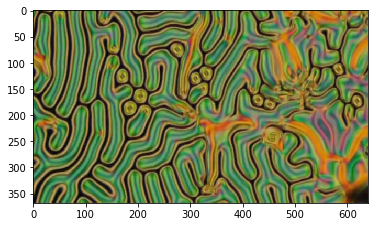

In [16]:
plt.imshow(images_test[74,:,:,:])
print("Label: %i"%labels_test[74])
print("Prediction: %i"%prediction[74])

In [18]:
print(prediction.shape)
print(labels_test.shape)

(112, 1)
(112, 1)


In [21]:
for i in range(len(prediction)):
    if prediction[i] == 1:
        print("Predicted that " + str(i) + " was a LC.")
        
for i in range(len(labels_test)):
    if labels_test[i] == 1:
        print(str(i) + " actually was a LC.")

Predicted that 1 was a LC.
Predicted that 2 was a LC.
Predicted that 3 was a LC.
Predicted that 4 was a LC.
Predicted that 5 was a LC.
Predicted that 12 was a LC.
Predicted that 18 was a LC.
Predicted that 23 was a LC.
Predicted that 26 was a LC.
Predicted that 34 was a LC.
Predicted that 36 was a LC.
Predicted that 37 was a LC.
Predicted that 39 was a LC.
Predicted that 40 was a LC.
Predicted that 41 was a LC.
Predicted that 42 was a LC.
Predicted that 47 was a LC.
Predicted that 48 was a LC.
Predicted that 50 was a LC.
Predicted that 53 was a LC.
Predicted that 54 was a LC.
Predicted that 56 was a LC.
Predicted that 61 was a LC.
Predicted that 64 was a LC.
Predicted that 68 was a LC.
Predicted that 70 was a LC.
Predicted that 73 was a LC.
Predicted that 74 was a LC.
Predicted that 75 was a LC.
Predicted that 76 was a LC.
Predicted that 77 was a LC.
Predicted that 78 was a LC.
Predicted that 79 was a LC.
Predicted that 80 was a LC.
Predicted that 81 was a LC.
Predicted that 82 was a L